<a href="https://colab.research.google.com/github/tneumann/htw_cnn_lecture/blob/master/002_convolutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ipython magic that ensures that plots are inlined and saved along with the notebook
%matplotlib inline

# import numpy - array processing library
import numpy as np 

# pytorch imports:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# pytorch functionality for image datasets
from torchvision import datasets, transforms

# standard plotting library
import matplotlib.pyplot as plt

In [2]:
batch_size = 128

train_data = datasets.MNIST(root='./data', train=True, 
                            download=True, transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(train_data, shuffle=False, batch_size=batch_size)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
X, y = next(iter(train_loader))
X.shape

torch.Size([128, 1, 28, 28])

([], <a list of 0 Text major ticklabel objects>)

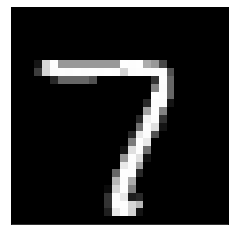

In [4]:
img = X[84, 0]
plt.gray()
plt.imshow(img)
plt.xticks([])
plt.yticks([])

In [5]:
kernel = torch.FloatTensor(
    [[-1, -1, -1], 
     [ 0,  0,  0],
     [ 1,  1,  1]]
).permute(1, 0)

([], <a list of 0 Text major ticklabel objects>)

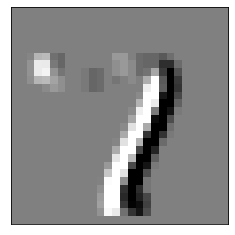

In [6]:
# create an output image of the same size as the input image "img"
out = torch.zeros_like(img)

# loop over the whole image, but ignore one pixel on the top, left, right and bottom
for x in range(1, 27):
    for y in range(1, 27):
        # compute the brightness of 
        #   the output pixel at x,y
        brightness = 0
        # for each pixel offset in -1, 0, 1
        for a in range(-1, 2):
            # for each pixel offset in -1, 0, 1
            for b in range(-1, 2):
                # get the brightness of the image at the offseted pixel
                b_img = img[y+b, x+a]
                # get the value of the kernel for that offset
                # need to add 1 in order to bring values from [-1, 0, 1] to [0, 1, 2]
                b_kernel = kernel[b+1, a+1]
                # multiply both and add to final brightness
                brightness += b_img * b_kernel
                
        out[y, x] = brightness

plt.imshow(out, vmin=-2, vmax=2)
plt.xticks([])
plt.yticks([])

([], <a list of 0 Text major ticklabel objects>)

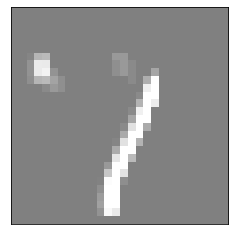

In [7]:
plt.imshow(nn.ReLU()(out), vmin=-2, vmax=2)
plt.xticks([])
plt.yticks([])

In [8]:
F.conv2d?

The dimensions of the input of conv2d are:
```
    (batch_size, in_channels, height, width)
```
    
The dimensions of the kernel ("weight") parameter in conv2d are:
```
    (out_channels, in_channels, kernel_height, kernel_width)
```
Since we have just one input channel, our batch_size is 1, and we only have one output channel, we can just add "empty" dimensions in order to get to this shape, and then call conv2d:

In [9]:
out2 = F.conv2d(img[None, None], kernel[None, None])
out2.shape

torch.Size([1, 1, 26, 26])

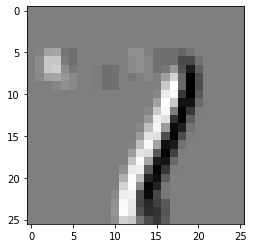

In [10]:
plt.imshow(out2[0, 0])

In [11]:
conv_layer = nn.Conv2d(1, 1, 3)
conv_layer

Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1))

In [12]:
out3 = conv_layer.forward(img[None, None])
out3.shape

torch.Size([1, 1, 26, 26])

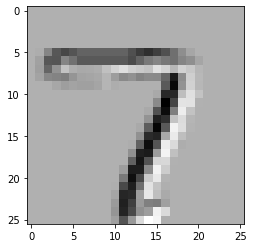

In [13]:
plt.imshow(out3.detach()[0, 0])

In [14]:
conv_layer.weight

Parameter containing:
tensor([[[[-0.0495,  0.1360, -0.2862],
          [ 0.3160,  0.2873, -0.2571],
          [-0.1819, -0.2294, -0.2341]]]], requires_grad=True)

# Multichannel

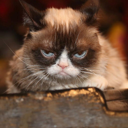

In [15]:
from PIL import Image
import requests
from io import BytesIO

response = requests.get("https://raw.githubusercontent.com/tneumann/htw_cnn_lecture/2020/grumpy_cat.jpg")
cat = Image.open(BytesIO(response.content)).resize((128, 128))
cat

In [16]:
img = transforms.ToTensor()(cat)
img.shape

torch.Size([3, 128, 128])

In [17]:
conv = nn.Conv2d(3, 4, 3, padding=1)
out = conv(img[None]).detach()
out.shape

torch.Size([1, 4, 128, 128])

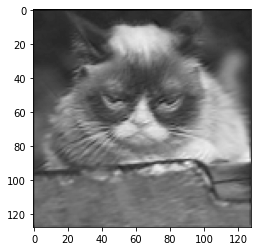

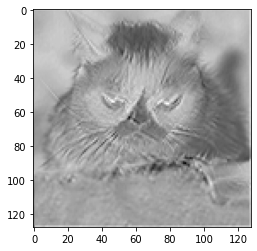

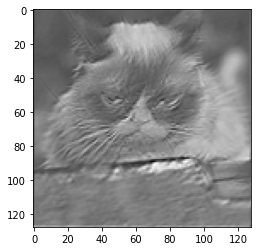

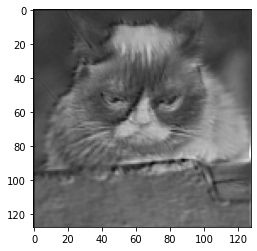

In [18]:
for out_channel in out[0]:
    plt.figure()
    plt.imshow(out_channel)
    

# Receptive fields

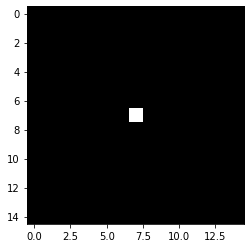

In [19]:
img = torch.zeros(15, 15)
img.data[7, 7] = 1
plt.imshow(img)

In [20]:
def ones_kernel(ksize):
    return torch.ones((1, 1, ksize, ksize))

ones_kernel(3)

tensor([[[[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]]]])

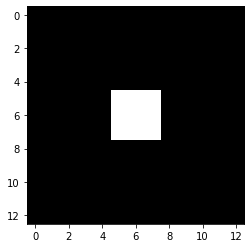

In [21]:
out = F.conv2d(img[None, None], ones_kernel(3))
plt.imshow(out[0, 0])

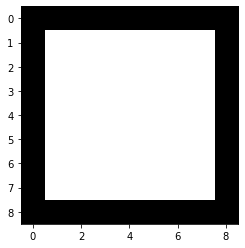

In [22]:
out = F.conv2d(img[None, None], ones_kernel(7))
plt.imshow(out[0, 0])

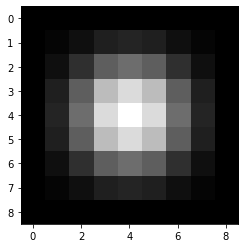

In [23]:
out1 = F.conv2d(img[None, None], ones_kernel(3))
out2 = F.conv2d(out1, ones_kernel(3))
out3 = F.conv2d(out2, ones_kernel(3))
plt.imshow(out3[0, 0])

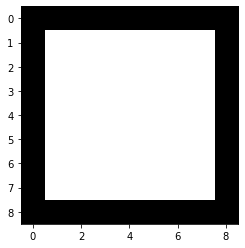

In [24]:
plt.imshow(out3[0, 0] > 0)

# Strides

In [25]:
F.conv2d(torch.randn((1, 1, 56, 56)), ones_kernel(3), stride=2, padding=1).shape

torch.Size([1, 1, 28, 28])